# Developpement du Modele

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

### Preparation des donnees

In [ ]:
# Charger les événements
events = pd.read_csv("/kaggle/input/events/events.csv")

In [ ]:
# Garder uniquement les colonnes utiles, y compris 'event'
events = events[["timestamp", "visitorid", "event", "itemid"]]

In [ ]:
# Convertir timestamp
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")

In [ ]:
# Trier les événements par utilisateur et par temps
events = events.sort_values(by=["visitorid", "timestamp"])

In [ ]:
# Définir les sessions avec 30 min d'inactivité
events["prev_timestamp"] = events.groupby("visitorid")["timestamp"].shift(1)
events["time_diff"] = (events["timestamp"] - events["prev_timestamp"]).dt.total_seconds()
events["new_session"] = (events["time_diff"] > 1800) | (events["time_diff"].isna())
events["session_id"] = events["new_session"].cumsum()


In [ ]:
# Charger item_properties_part1.csv
props = pd.read_csv("/kaggle/input/item-properties/item_properties_part1.csv")

In [ ]:
# Garder uniquement les propriétés "categoryid"
props = props[props["property"] == "categoryid"]
props["timestamp"] = pd.to_datetime(props["timestamp"], unit="ms")

In [ ]:
# Prendre la dernière valeur de categoryid connue par itemid
props = props.sort_values("timestamp").drop_duplicates("itemid", keep="last")
props = props[["itemid", "value"]].rename(columns={"value": "categoryid"})

In [ ]:
# Fusionner pour ajouter la catégorie
events = events.merge(props, on="itemid", how="left")

In [ ]:
# Sauvegarde du résultat
events.to_csv("cleaned_sessions.csv", index=False)


In [ ]:
# Affichage
print(events.head(10))

#####

### Developpement du modele

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Definition du modèle : prédit à la fois l'item et l'event
class GRUItemEventModel(nn.Module):
    def __init__(self, num_items, num_events, embedding_dim, hidden_size):
        super().__init__()
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.event_embedding = nn.Embedding(num_events, embedding_dim)
        self.gru = nn.GRU(embedding_dim * 2, hidden_size, batch_first=True)
        self.item_fc = nn.Linear(hidden_size, num_items)
        self.event_fc = nn.Linear(hidden_size, num_events)

    def forward(self, item_seq, event_seq):
        item_emb = self.item_embedding(item_seq)
        event_emb = self.event_embedding(event_seq)
        x = torch.cat([item_emb, event_emb], dim=2)
        out, _ = self.gru(x)
        out = out.contiguous().view(-1, out.size(2))
        item_out = self.item_fc(out)
        event_out = self.event_fc(out)
        return item_out.view(item_seq.size(0), item_seq.size(1), -1), \
               event_out.view(item_seq.size(0), item_seq.size(1), -1)

In [5]:
# Données
path = "/kaggle/input/cleaned-sessions/cleaned_sessions.csv"
df = pd.read_csv(path)
df = df[df['event'].isin(['view', 'addtocart', 'transaction'])]
item_encoder = LabelEncoder()
df['itemid_enc'] = item_encoder.fit_transform(df['itemid'])
event_encoder = {'view': 0, 'addtocart': 1, 'transaction': 2}
df['event_type'] = df['event'].map(event_encoder)
df = df.sort_values(['session_id', 'timestamp'])
sessions = df.groupby('session_id').apply(lambda x: list(zip(x['itemid_enc'], x['event_type']))).tolist()
session_data = [s for s in sessions if len(s) > 1]

/tmp/ipykernel_35/1985710261.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions = df.groupby('session_id').apply(lambda x: list(zip(x['itemid_enc'], x['event_type']))).tolist()


In [6]:
# Diviser les donnees en train/val/test
train_sessions, temp_sessions = train_test_split(session_data, test_size=0.25, random_state=42)
val_sessions, test_sessions = train_test_split(temp_sessions, test_size=0.5, random_state=42)


In [7]:
MAX_SEQ_LEN = 20

# Batch generator

def generate_batch_event(session_data, batch_size):
    np.random.shuffle(session_data)
    for i in range(0, len(session_data) - batch_size, batch_size):
        batch = session_data[i:i + batch_size]
        item_inputs, event_inputs, item_targets, event_targets = [], [], [], []
        for s in batch:
            items = [x[0] for x in s[:-1]][-MAX_SEQ_LEN:]
            events = [x[1] for x in s[:-1]][-MAX_SEQ_LEN:]
            item_tgts = [x[0] for x in s[1:]][-MAX_SEQ_LEN:]
            event_tgts = [x[1] for x in s[1:]][-MAX_SEQ_LEN:]

            item_inputs.append(torch.tensor(items))
            event_inputs.append(torch.tensor(events))
            item_targets.append(torch.tensor(item_tgts))
            event_targets.append(torch.tensor(event_tgts))

        yield pad_sequence(item_inputs, batch_first=True), \
              pad_sequence(event_inputs, batch_first=True), \
              pad_sequence(item_targets, batch_first=True), \
              pad_sequence(event_targets, batch_first=True)

In [8]:
# Entraînement
EPOCHS = 30
BATCH_SIZE = 64
model = GRUItemEventModel(len(item_encoder.classes_), 3, 200, 200).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
item_criterion = nn.CrossEntropyLoss()
event_criterion = nn.CrossEntropyLoss()

best_val_recall = 0
best_model_state = None
patience = 3
wait = 0

for epoch in range(EPOCHS):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    for item_in, event_in, item_target, event_target in generate_batch_event(train_sessions, BATCH_SIZE):
        item_in, event_in = item_in.to(device), event_in.to(device)
        item_target, event_target = item_target.to(device), event_target.to(device)

        item_out, event_out = model(item_in, event_in)

        item_loss = item_criterion(item_out.view(-1, item_out.size(-1)), item_target.view(-1))
        event_loss = event_criterion(event_out.view(-1, event_out.size(-1)), event_target.view(-1))
        loss = item_loss + event_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_recall = []
    for session in val_sessions[:1000]:
        items = [x[0] for x in session[:-1]][-MAX_SEQ_LEN:]
        events = [x[1] for x in session[:-1]][-MAX_SEQ_LEN:]
        target_item = session[-1][0]
        item_tensor = torch.LongTensor(items).unsqueeze(0).to(device)
        event_tensor = torch.LongTensor(events).unsqueeze(0).to(device)

        with torch.no_grad():
            item_out, event_out = model(item_tensor, event_tensor)
            last_item_logits = item_out[0, -1]
            top_k = torch.topk(torch.softmax(last_item_logits, dim=0), 5).indices.tolist()
        val_recall.append(int(target_item in top_k))

    avg_val_recall = np.mean(val_recall)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Recall@5: {avg_val_recall:.4f}")

    if avg_val_recall > best_val_recall:
        best_val_recall = avg_val_recall
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Sauvegarde
if best_model_state:
    torch.save(best_model_state, "gru_dual_output_best.pth")


Epoch 1/30 | Loss: 8290.3246 | Val Recall@5: 0.1270
Epoch 2/30 | Loss: 6572.3109 | Val Recall@5: 0.2450
Epoch 3/30 | Loss: 5437.9265 | Val Recall@5: 0.3140
Epoch 4/30 | Loss: 4728.8507 | Val Recall@5: 0.3520
Epoch 5/30 | Loss: 4157.4540 | Val Recall@5: 0.3860
Epoch 6/30 | Loss: 3681.9889 | Val Recall@5: 0.3940
Epoch 7/30 | Loss: 3310.9810 | Val Recall@5: 0.4040
Epoch 8/30 | Loss: 2992.9365 | Val Recall@5: 0.4130
Epoch 9/30 | Loss: 2699.6996 | Val Recall@5: 0.4180
Epoch 10/30 | Loss: 2460.4459 | Val Recall@5: 0.4150
Epoch 11/30 | Loss: 2268.2769 | Val Recall@5: 0.4070
Epoch 12/30 | Loss: 2095.2736 | Val Recall@5: 0.4170
Early stopping triggered.


## Evaluation du modele

In [11]:
# Fonctions qui calcule les metriques

def recall_at_k(target, predictions, k):
    return int(target in predictions[:k])

def precision_at_k(target, predictions, k):
    return int(target in predictions[:k]) / k

def mrr_at_k(target, predictions, k):
    try:
        rank = predictions[:k].index(target)
        return 1.0 / (rank + 1)
    except ValueError:
        return 0.0

def hitrate_at_k(target, predictions, k):
    return int(target in predictions[:k])

def ndcg_at_k(target, predictions, k):
    try:
        rank = predictions[:k].index(target)
        return 1.0 / np.log2(rank + 2)
    except ValueError:
        return 0.0

def f1_at_k(target, predictions, k):
    p = precision_at_k(target, predictions, k)
    r = recall_at_k(target, predictions, k)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0.0


In [17]:
# Fonction pour evaluer le modele selon K
def evaluate_model(K_item, K_event=3):
    model.eval()
    scores1 = {"recall": [], "mrr": [], "precision": [], "hitrate": [], "ndcg": [], "f1": []}
    scores2 = {"recall": [], "mrr": [], "precision": [], "hitrate": [], "ndcg": [], "f1": []}

    for session in tqdm(test_sessions[:1000]):
        items = [x[0] for x in session[:-1]][-MAX_SEQ_LEN:]
        events = [x[1] for x in session[:-1]][-MAX_SEQ_LEN:]
        item_target = session[-1][0]
        event_target = session[-1][1]

        item_tensor = torch.LongTensor(items).unsqueeze(0).to(device)
        event_tensor = torch.LongTensor(events).unsqueeze(0).to(device)

        with torch.no_grad():
            item_out, event_out = model(item_tensor, event_tensor)
            item_probs = torch.softmax(item_out[0, -1], dim=0)
            event_probs = torch.softmax(event_out[0, -1], dim=0)

            topk_items = torch.topk(item_probs, K_item).indices.tolist()
            topk_events = torch.topk(event_probs, min(K_event, event_probs.size(0))).indices.tolist()

        # Méthode 1
        scores1["recall"].append(recall_at_k(item_target, topk_items, K_item))
        scores1["mrr"].append(mrr_at_k(item_target, topk_items, K_item))
        scores1["precision"].append(precision_at_k(item_target, topk_items, K_item))
        scores1["hitrate"].append(hitrate_at_k(item_target, topk_items, K_item))
        scores1["ndcg"].append(ndcg_at_k(item_target, topk_items, K_item))
        scores1["f1"].append(f1_at_k(item_target, topk_items, K_item))

        # Méthode 2
        correct_pair_found = False
        mrr_pair = 0.0
        found_index = -1
        for rank, (i_pred, e_pred) in enumerate(zip(topk_items, topk_events)):
            if i_pred == item_target and e_pred == event_target:
                correct_pair_found = True
                mrr_pair = 1.0 / (rank + 1)
                found_index = rank
                break

        scores2["recall"].append(int(correct_pair_found))
        scores2["mrr"].append(mrr_pair)
        scores2["precision"].append(int(correct_pair_found) / K_item)
        scores2["hitrate"].append(int(correct_pair_found))
        scores2["ndcg"].append(1.0 / np.log2(found_index + 2) if correct_pair_found else 0.0)
        scores2["f1"].append(
            (2 * (int(correct_pair_found) / K_item)) / (1 + 1) if correct_pair_found else 0.0
        )
    
    return scores1, scores2

In [19]:
# Évaluer pour K=5, K=10, K=20
method1_k5, method2_k5 = evaluate_model(K_item=5, K_event=3)
method1_k10, method2_k10 = evaluate_model(K_item=10, K_event=3)
method1_k20, method2_k20 = evaluate_model(K_item=20, K_event=3)

100%|██████████| 1000/1000 [00:01<00:00, 550.75it/s]


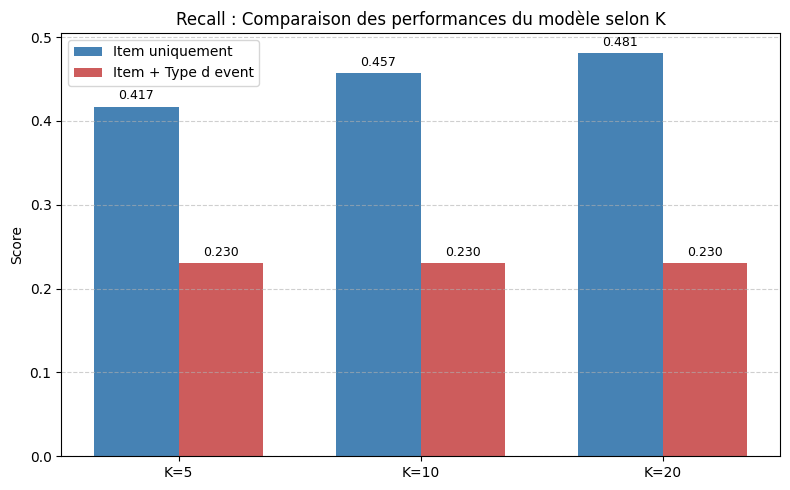

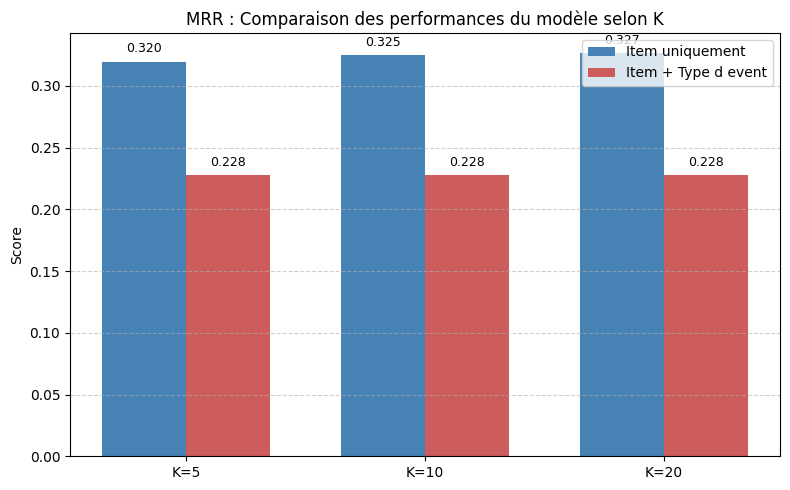

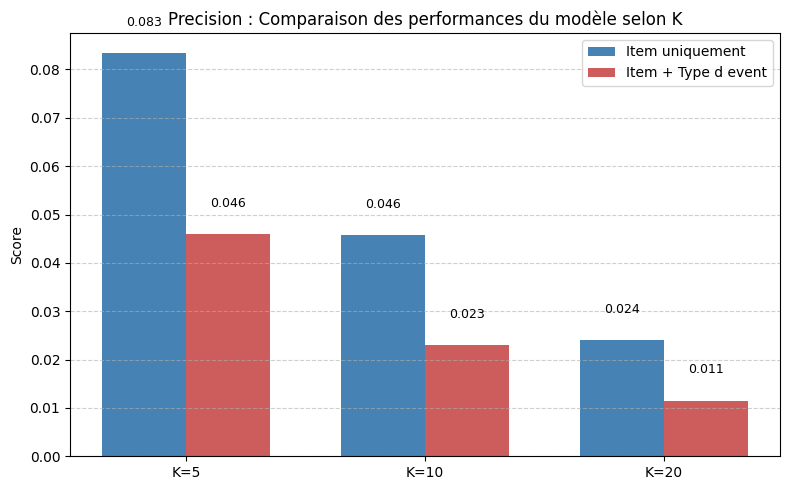

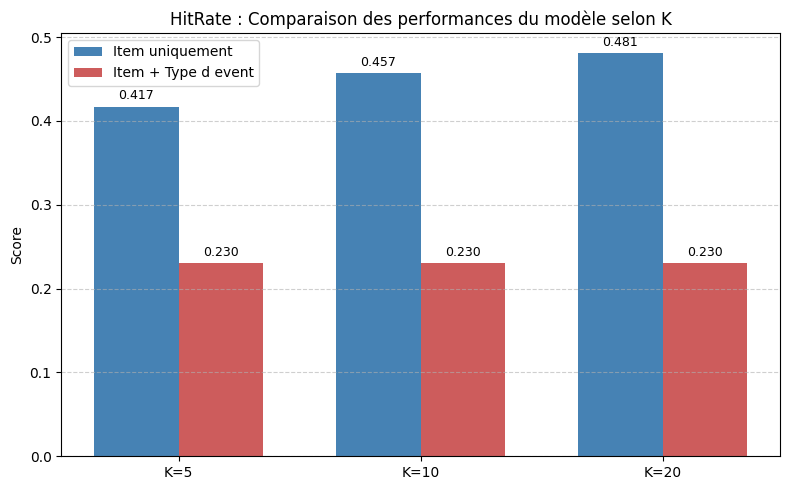

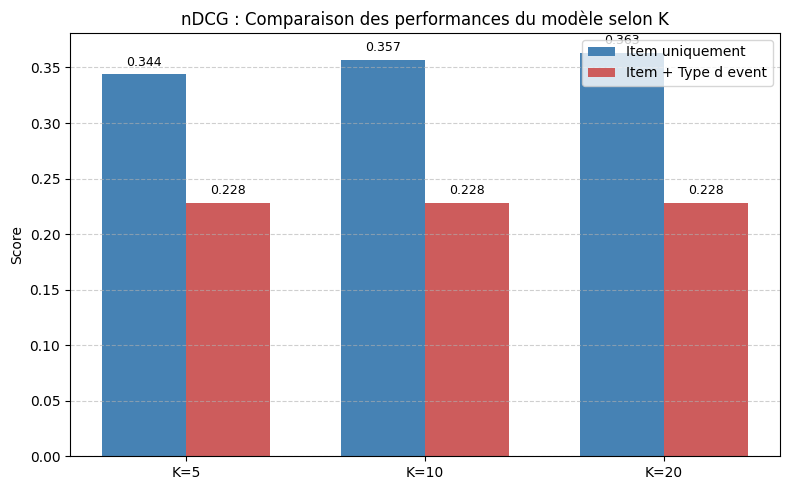

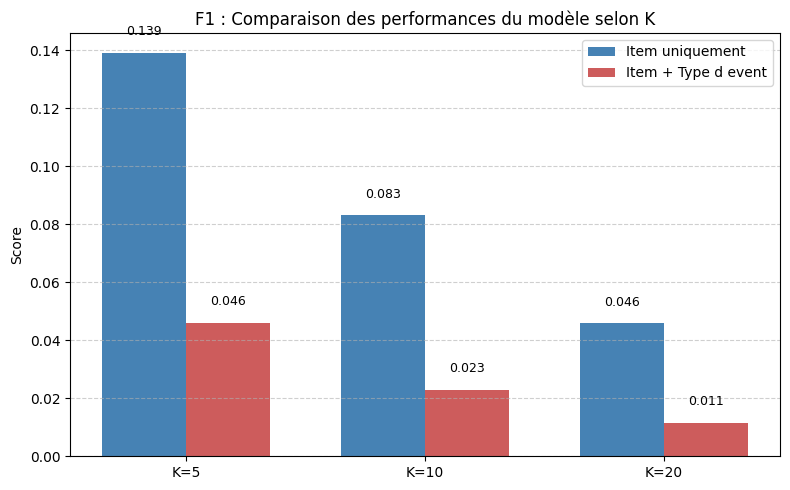

In [25]:
# Fonction pour la visualisation des resultats

def plot_comparison(metric_name):
    metrics = ["recall", "mrr", "precision", "hitrate", "ndcg", "f1"]
    idx = metrics.index(metric_name)

    labels = ["Recall", "MRR", "Precision", "HitRate", "nDCG", "F1"]
    display_label = labels[idx]

    method1 = [
        np.mean(method1_k5[metric_name]),
        np.mean(method1_k10[metric_name]),
        np.mean(method1_k20[metric_name])
    ]
    method2 = [
        np.mean(method2_k5[metric_name]),
        np.mean(method2_k10[metric_name]),
        np.mean(method2_k20[metric_name])
    ]

    x = np.arange(3)  # K=5, K=10, K=20
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, method1, width, label='Item uniquement', color='steelblue')
    bars2 = ax.bar(x + width/2, method2, width, label='Item + Type d event', color='indianred')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(["K=5", "K=10", "K=20"])
    ax.set_ylabel('Score')
    ax.set_title(f"{display_label} : Comparaison des performances du modèle selon K")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Tracer toutes les métriques
for metric in ["recall", "mrr", "precision", "hitrate", "ndcg", "f1"]:
    plot_comparison(metric)


### Sauvgardage du modele complet

In [26]:
import pickle

# Sauvegarde du meilleur modèle + encoders
if best_model_state:
    checkpoint = {
        'model_state_dict': best_model_state,
        'item_encoder': item_encoder,
        'event_encoder': event_encoder  # ici c’est juste un dictionnaire simple
    }

    torch.save(checkpoint, "Modele_GRU_Complet.pth")
    print("Modèle et encoders sauvegardés dans 'Modele_GRU_Complet.pth'")


Modèle et encoders sauvegardés dans 'Modele_GRU_Complet.pth'
